<span style="color:black; font-family:Helvetica; font-size:2.5em;">Practical Code to Calculating Customer Lifetime Value (CLV)</span>

<span style="color:gray; font-family:Helvetica; font-size:1em;"><b>Customer Lifetime Value (CLV)</b> is an estimation of the entire net profit attributed to a single customer. It’s an important metric to understand because it helps businesses determine how much is too much to spend on advertising to acquire a single customer.</span>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

<span style="color:black; font-family:Helvetica; font-size:2.5em;">Data Exploration</span>

<span style="color:gray; font-family:Helvetica; font-size:1em;">For this example we’ll calculate CLV from a dataset of roughly 4,200 transactions.</span>

In [3]:
data = pd.read_csv('/Users/crucker/Desktop/clv_transactions.csv')
data.head(6)

,TransactionID,TransactionDate,CustomerID,Amount
0,1,2012-09-04,1,20.96
1,2,2012-05-15,2,10.87
2,3,2014-05-23,2,2.21
3,4,2014-10-24,2,10.48
4,5,2012-10-13,2,3.94
5,6,2013-01-23,2,12.37


In [176]:
data.tail(6)

,TransactionID,TransactionDate,CustomerID,Amount
4175,4176,2012-09-18,1000,9.69
4176,4177,2013-06-23,1000,3.86
4177,4178,2011-08-07,1000,4.00
4178,4179,2012-10-07,1000,18.37
4179,4180,2014-01-09,1000,3.65
4180,4181,2011-04-30,1000,5.18


In [177]:
Transactions = data['CustomerID'].count()

In [178]:
Customers = data['CustomerID'].max()

In [179]:
MinTransactionDate = data['TransactionDate'].min()

In [180]:
MaxTransactionDate = data['TransactionDate'].max()

In [181]:
Amount = data['Amount'].sum()

In [182]:
summary = [Transactions, Customers, MinTransactionDate, MaxTransactionDate, round(Amount, 2)]
summary

[4181, 1000, '2010-01-04', '2015-12-31', 33729.91]

<span style="color:gray; font-family:Helvetica; font-size:1em;">As with any analysis, the first thing we’ll do is look at some basic summary statistics.</span>

In [9]:
data = {'Transactions': [4181], 
        'Customers': [1000], 
        'MinTransactionDate': ['2010-01-04'],
        'MaxTransactionDate': ['2015-12-31'],
        'Amount': [33729.91]}
df = pd.DataFrame(data, index = [''])
df

,Amount,Customers,MaxTransactionDate,MinTransactionDate,Transactions
,33729.91,1000,2015-12-31,2010-01-04,4181


In [210]:
TransactionsPerCustomer = round(Transactions / Customers, 2)
TransactionsPerCustomer

4.0

In [211]:
AmountPerTransaction = round(Amount / Transactions, 2)
AmountPerTransaction

8.07

In [212]:
AmountPerCustomer = round(Amount / Customers, 2)
AmountPerCustomer

33.73

<span style="color:gray; font-family:Helvetica; font-size:1em;">Note that the data consists of 1000 customers who made transactions between 2010 and 2015. Furthermore, each customer made about 4 transactions for 8 bucks a piece, totaling close to $34. This amount can be considered a lower bound on CLV since it’s the total amount spent by each customer, but we still expect existing customers to make future purchases.</span>

In [213]:
data = {'TransactionsPerCustomer': [4.0], 
        'AmountPerTransaction': [8.07], 
        'AmountPerCustomer': [33.73]}
df = pd.DataFrame(data, index = [''])
df

,AmountPerCustomer,AmountPerTransaction,TransactionsPerCustomer
,33.73,8.07,4


In [214]:
more_summary = [TransactionsPerCustomer, AmountPerTransaction, AmountPerCustomer]
more_summary

[4.0, 8.07, 33.73]

<span style="color:gray; font-family:Helvetica; font-size:1em;">We need to consider outlier transactions and should remove the transactions from the data entirely. Here we inspect the largest transactions.</span>

In [4]:
data.loc[data['Amount'] >= 29.99]

,TransactionID,TransactionDate,CustomerID,Amount
52,53,2015-01-29,13,37.27
260,261,2012-06-21,69,38.29
415,416,2013-12-31,100,30.31
582,583,2013-03-16,145,30.43
1341,1342,2013-06-28,345,29.99
2270,2271,2013-04-13,573,32.81
2487,2488,2011-07-13,632,36.94
2641,2642,2011-05-16,663,31.40
2757,2758,2013-08-31,691,38.35
3960,3961,2013-07-28,957,30.01


In [6]:
import seaborn as sns
sns.set(color_codes=True)

<span style="color:black; font-family:Helvetica; font-size:2.5em;">Plotting Univariate Distributions</span>

<span style="color:gray; font-family:Helvetica; font-size:1em;">We could use a statistical test to check for outliers, but here it’s pretty clear that none exist.  Plotting the entire distribution of transaction amounts should give us more confidence in our assertion.</span>

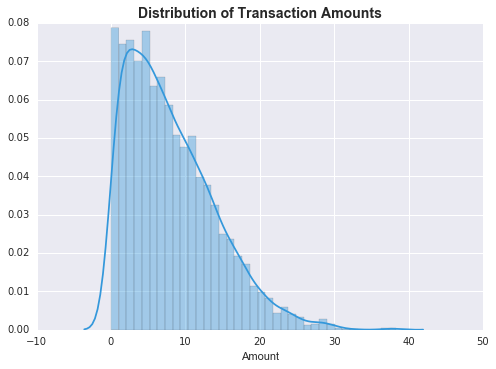

In [8]:
plt.title('Distribution of Transaction Amounts', fontsize=14, fontweight="bold")
sns.distplot(data.Amount, color='#3498db')

<span style="color:black; font-family:Helvetica; font-size:2.5em;">Measuring Historic CLV</span>

<span style="color:gray; font-family:Helvetica; font-size:1em;">Now we need to consider the biggest source of error in our $34 CLV lower bound – some of the underlying customers are brand new and others have been customers for almost five years. Obviously the newer customers will have (generally) spent less on average than the old ones. So, we need to separate the customers into groups based on how long ago they were acquired (e.g. customers acquired in 2010, vs customers acquired in 2011, …).</span>

<span style="color:gray; font-family:Helvetica; font-size:1em;">Since we have 5 years worth of data, let’s separate customers into annual origin periods starting on 2010-01-01, and measure their purchases annually.</span>